このデータセットを使用

https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

## Kaggle のデータをGoogle colabで利用するための処理

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import json
f = open("/content/drive/MyDrive/TechnicalChallenge/kaggle.json")
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [4]:
!kaggle datasets download -d sakshigoyal7/credit-card-customers

credit-card-customers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -o '/content/credit-card-customers.zip'

Archive:  /content/credit-card-customers.zip
  inflating: BankChurners.csv        


## 取得したKaggleのデータを分析する

### パッケージインポート

In [6]:
# 必要なパッケージをインポートする
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('/content/BankChurners.csv')
df = df[df.columns[:-2]]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

### Datatypeがobjectなカラム確認してプロットする

In [9]:
columns_list = df.columns.tolist()

object_clums_list = []

for column in columns_list:
    if(df[column].dtype == 'object'):
        object_clums_list.append(column)

object_clums_list

['Attrition_Flag',
 'Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

--------------------------------------------------
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64


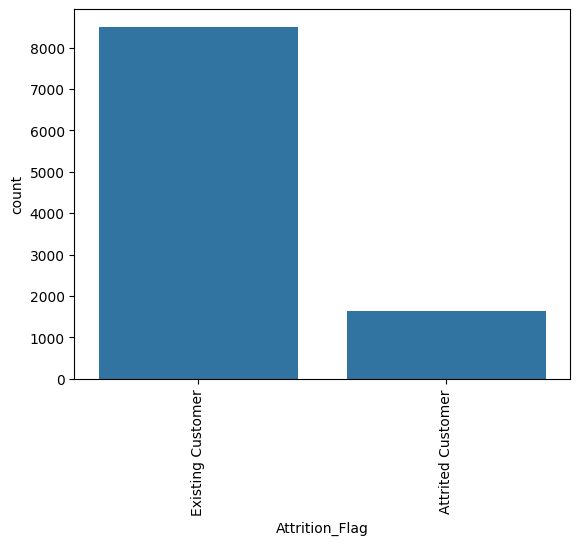

--------------------------------------------------
--------------------------------------------------
Gender
F    5358
M    4769
Name: Gender, dtype: int64


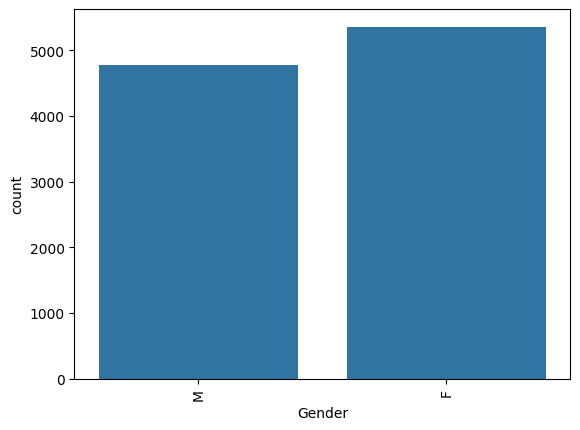

--------------------------------------------------
--------------------------------------------------
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64


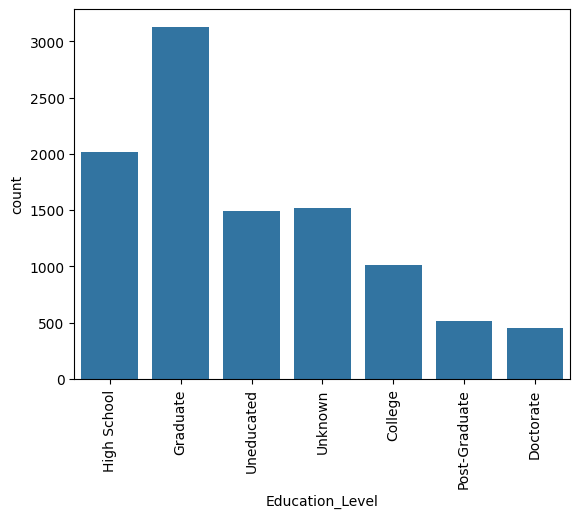

--------------------------------------------------
--------------------------------------------------
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64


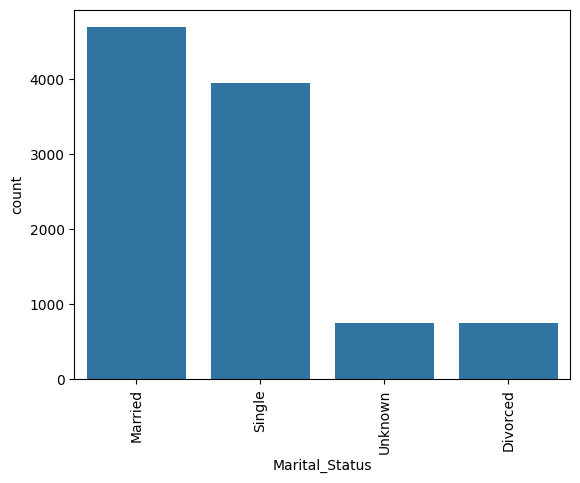

--------------------------------------------------
--------------------------------------------------
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64


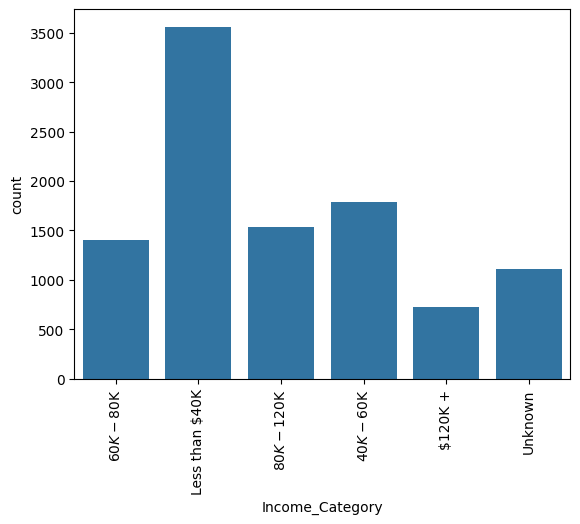

--------------------------------------------------
--------------------------------------------------
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


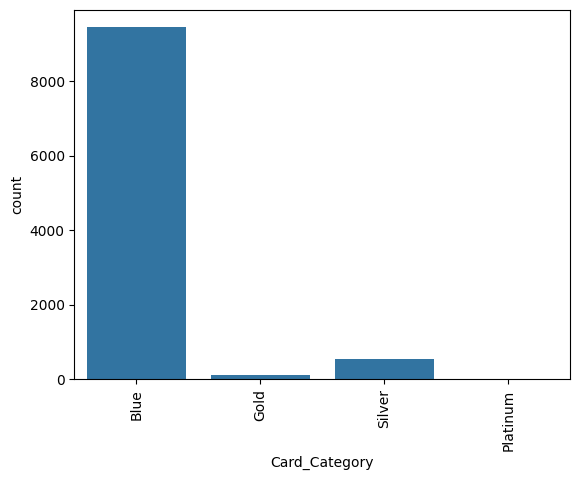

--------------------------------------------------


In [10]:
for column in object_clums_list:
    print('-----'*10)
    print(column)
    print(df[column].value_counts())
    plt.xticks(rotation=90)
    sns.countplot(x=column, data=df)
    plt.show()
    print('-----'*10)

### 前処理

#### Unknownデータを取り除く

In [11]:
df_drop = df.drop('CLIENTNUM', axis=1)
df_drop = df_drop[df_drop['Education_Level']!='Unknown']
df_drop = df_drop[df_drop['Marital_Status']!='Unknown']
df_drop = df_drop[df_drop['Income_Category']!='Unknown']
df_drop

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,Existing Customer,54,M,1,High School,Single,$60K - $80K,Blue,34,5,2,0,13940.0,2109,11831.0,0.660,15577,114,0.754,0.151
10121,Existing Customer,56,F,1,Graduate,Single,Less than $40K,Blue,50,4,1,4,3688.0,606,3082.0,0.570,14596,120,0.791,0.164
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


--------------------------------------------------
Attrition_Flag
Existing Customer    5968
Attrited Customer    1113
Name: Attrition_Flag, dtype: int64


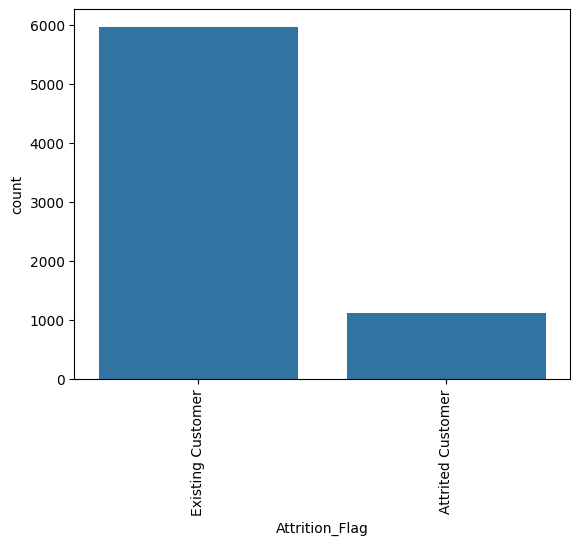

--------------------------------------------------
--------------------------------------------------
Gender
M    3706
F    3375
Name: Gender, dtype: int64


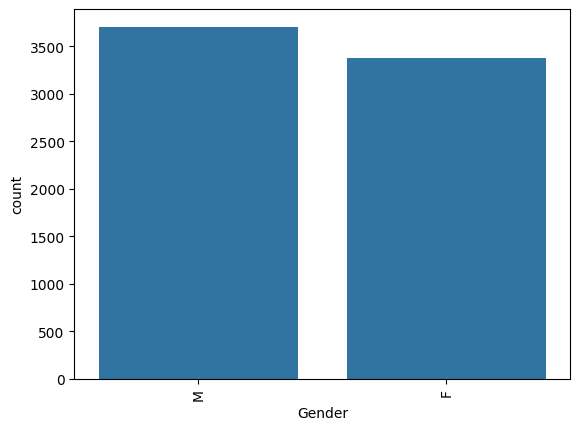

--------------------------------------------------
--------------------------------------------------
Education_Level
Graduate         2591
High School      1653
Uneducated       1204
College           844
Post-Graduate     431
Doctorate         358
Name: Education_Level, dtype: int64


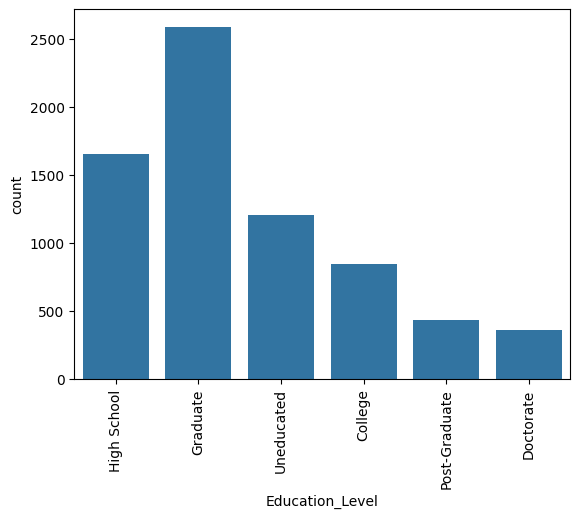

--------------------------------------------------
--------------------------------------------------
Marital_Status
Married     3564
Single      2948
Divorced     569
Name: Marital_Status, dtype: int64


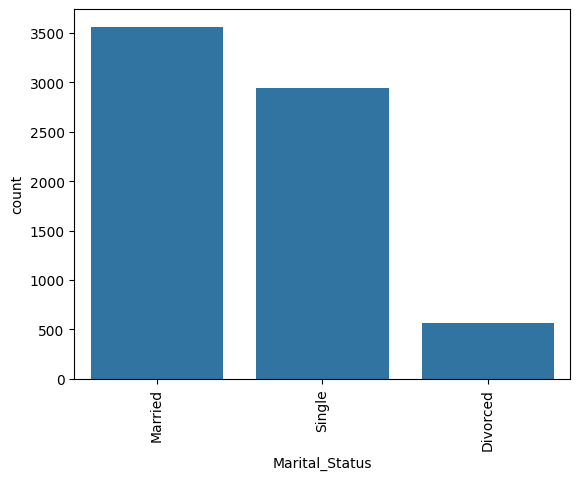

--------------------------------------------------
--------------------------------------------------
Income_Category
Less than $40K    2792
$40K - $60K       1412
$80K - $120K      1202
$60K - $80K       1103
$120K +            572
Name: Income_Category, dtype: int64


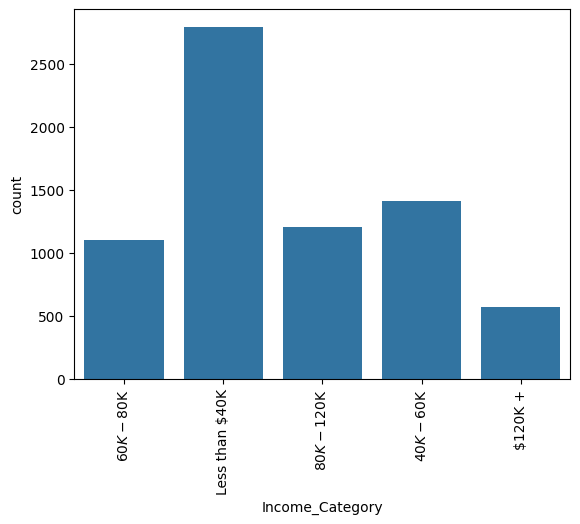

--------------------------------------------------
--------------------------------------------------
Card_Category
Blue        6598
Silver       391
Gold          81
Platinum      11
Name: Card_Category, dtype: int64


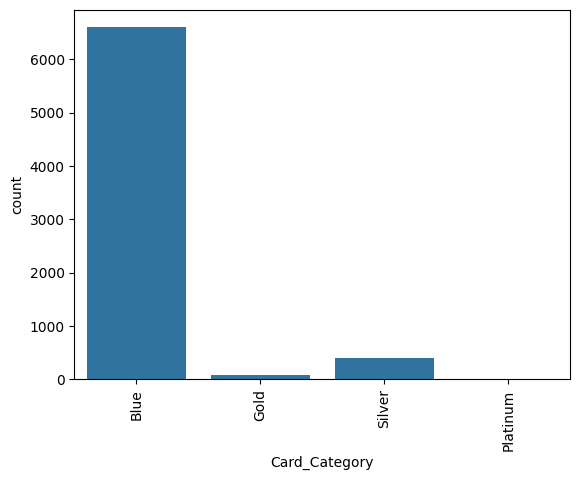

--------------------------------------------------


In [12]:
for column in object_clums_list:
    print('-----'*10)
    print(column)
    print(df_drop[column].value_counts())
    plt.xticks(rotation=90)
    sns.countplot(x=column, data=df_drop)
    plt.show()
    print('-----'*10)

#### objectカラムを変換する

In [13]:
new_df = pd.get_dummies(df_drop, columns=['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Gender'])
new_df['Attrition_Flag'] = new_df['Attrition_Flag'].replace('Attrited Customer', 1).replace('Existing Customer', 0)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7081 entries, 0 to 10126
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Attrition_Flag                  7081 non-null   int64  
 1   Customer_Age                    7081 non-null   int64  
 2   Dependent_count                 7081 non-null   int64  
 3   Months_on_book                  7081 non-null   int64  
 4   Total_Relationship_Count        7081 non-null   int64  
 5   Months_Inactive_12_mon          7081 non-null   int64  
 6   Contacts_Count_12_mon           7081 non-null   int64  
 7   Credit_Limit                    7081 non-null   float64
 8   Total_Revolving_Bal             7081 non-null   int64  
 9   Avg_Open_To_Buy                 7081 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            7081 non-null   float64
 11  Total_Trans_Amt                 7081 non-null   int64  
 12  Total_Trans_Ct                  7

#### 標準化する

In [14]:
new_df_columns = new_df.columns.tolist()
new_df_columns.remove('Attrition_Flag')

std_scaler = StandardScaler()

for column in new_df_columns:
    new_df[column] = std_scaler.fit_transform(new_df[column].values.reshape(-1,1))

new_df.describe()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Gender_F,Gender_M
count,7081.000000,7.081000e+03,7.081000e+03,7.081000e+03,7081.000000,7.081000e+03,7.081000e+03,7.081000e+03,7.081000e+03,7.081000e+03,...,7.081000e+03,7.081000e+03,7.081000e+03,7.081000e+03,7.081000e+03,7081.000000,7.081000e+03,7.081000e+03,7.081000e+03,7.081000e+03
mean,0.157181,4.816559e-17,-5.619318e-17,-2.809659e-17,0.000000,-1.525244e-16,-8.027598e-17,-4.816559e-17,4.013799e-18,1.605520e-17,...,-2.207589e-17,3.211039e-17,-4.013799e-17,-5.619318e-17,-1.204140e-17,0.000000,-1.605520e-17,8.027598e-18,-6.422078e-17,6.422078e-17
std,0.363997,1.000071e+00,1.000071e+00,1.000071e+00,1.000071,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,...,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,0.000000,-2.530601e+00,-1.810066e+00,-2.871936e+00,-1.825624,-2.354300e+00,-2.221550e+00,-7.730568e-01,-1.437353e+00,-8.019510e-01,...,-4.990731e-01,-4.295461e-01,-4.521687e-01,-8.068256e-01,-3.696005e+00,-0.107571,-3.944452e-02,-2.417549e-01,-9.542984e-01,-1.047890e+00
25%,0.000000,-6.650813e-01,-1.035808e+00,-6.225108e-01,-0.530569,-3.443171e-01,-4.113319e-01,-6.569307e-01,-8.673370e-01,-6.655959e-01,...,-4.990731e-01,-4.295461e-01,-4.521687e-01,-8.068256e-01,2.705624e-01,-0.107571,-3.944452e-02,-2.417549e-01,-9.542984e-01,-1.047890e+00
50%,0.000000,-4.324162e-02,-2.615488e-01,2.329584e-03,0.116959,-3.443171e-01,-4.113319e-01,-4.608851e-01,1.409630e-01,-4.463326e-01,...,-4.990731e-01,-4.295461e-01,-4.521687e-01,-8.068256e-01,2.705624e-01,-0.107571,-3.944452e-02,-2.417549e-01,-9.542984e-01,9.542984e-01
75%,0.000000,7.029661e-01,5.127100e-01,5.022019e-01,0.764487,6.606744e-01,4.937772e-01,2.450544e-01,7.552997e-01,2.371952e-01,...,-4.990731e-01,-4.295461e-01,-4.521687e-01,1.239425e+00,2.705624e-01,-0.107571,-3.944452e-02,-2.417549e-01,1.047890e+00,9.542984e-01
max,1.000000,3.314693e+00,2.061228e+00,2.501691e+00,1.412015,3.675649e+00,3.209104e+00,2.851727e+00,1.661415e+00,2.977987e+00,...,2.003715e+00,2.328039e+00,2.211564e+00,1.239425e+00,2.705624e-01,9.296223,2.535207e+01,4.136420e+00,1.047890e+00,9.542984e-01


## 前処理のみしたデータで検証



### 相関を確認

<Axes: >

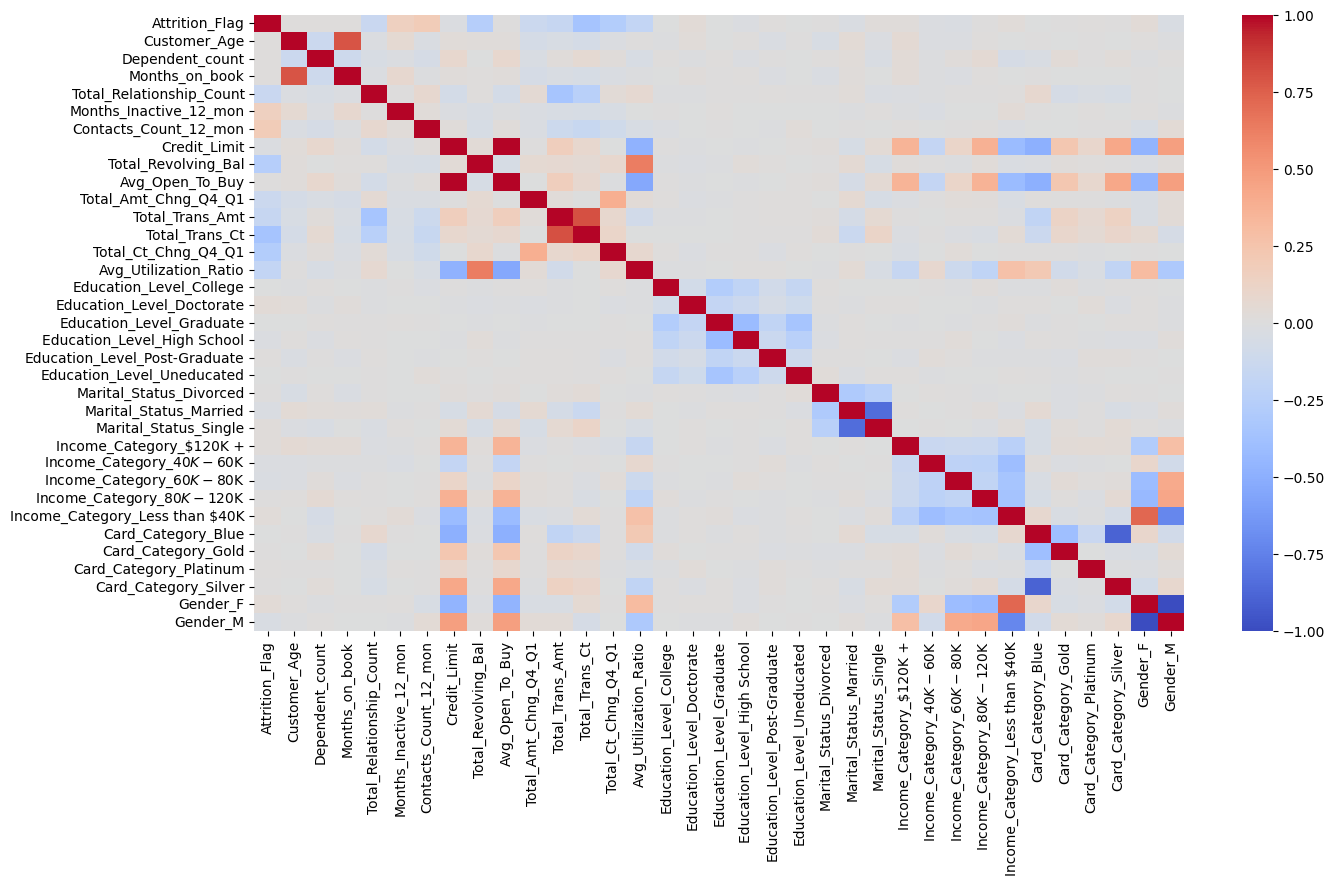

In [15]:
df_corr = new_df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(df_corr, cmap='coolwarm', vmax=1.0,vmin=-1.0)

In [16]:
df_class_corr = df_corr['Attrition_Flag']
df_class_corr.sort_values(ascending=False)

Attrition_Flag                    1.000000
Contacts_Count_12_mon             0.193923
Months_Inactive_12_mon            0.152732
Gender_F                          0.035358
Education_Level_Doctorate         0.033169
Income_Category_Less than $40K    0.027114
Marital_Status_Single             0.022535
Income_Category_$120K +           0.017218
Education_Level_Post-Graduate     0.015019
Card_Category_Platinum            0.012522
Dependent_count                   0.011423
Months_on_book                    0.009249
Customer_Age                      0.008735
Avg_Open_To_Buy                   0.007802
Marital_Status_Divorced           0.003659
Card_Category_Silver              0.002620
Card_Category_Gold                0.000979
Income_Category_$80K - $120K      0.000070
Education_Level_College          -0.000791
Education_Level_Graduate         -0.001012
Education_Level_Uneducated       -0.003353
Card_Category_Blue               -0.004743
Credit_Limit                     -0.015815
Income_Cate

### ライブラリを使ってクラス分類を行う

In [17]:
# モデルのクロスバリデーションとモデル作成する関数
def model_fitting(model, X_train, X_test, y_train, y_test):

    scoring = ['accuracy', 'precision', 'recall', 'f1']

    scores = cross_validate(model, X_train, y_train, scoring=scoring)

    for key,value in scores.items():
        print("{}:{:.4f}".format(key, value.mean()))

    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)

    cnf_matrix = confusion_matrix(y_true=y_test, y_pred=Y_pred)

    DetaFrame_cm = pd.DataFrame(cnf_matrix)
    sns.heatmap(DetaFrame_cm, annot=True, fmt='d').set_title('Confusion matrix result')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.show()

    print('accuracy = ', round(accuracy_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')
    print('precision = ', round(precision_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')
    print('recall = ', round(recall_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')
    print('f1 score = ', round(f1_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')

    return model

### 学習データとテストデータに分ける

In [18]:
X = new_df.drop('Attrition_Flag', axis=1)
y = new_df['Attrition_Flag']

# 80%のデータを学習データに、20%を検証データにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### ロジスティック回帰

In [19]:
# ロジスティック回帰モデルの特徴量重要度を可視化する関数
def LR_regression_coefficients_per_feature(LR_model, X_train):
    coefs_df = pd.DataFrame(
        data={"coef": LR_model.coef_.squeeze().tolist()}, index=X_train.columns.tolist()
    ).sort_values("coef", ascending=True)

    plt.rcParams["axes.axisbelow"] = True
    plt.barh(coefs_df.index.to_list(), coefs_df["coef"].to_list(), align="center")

    plt.title("Regression coefficients per feature")
    plt.xlabel("regression coefficient")
    plt.ylabel("feature")
    plt.grid(visible=True)

    plt.show()

fit_time:0.0667
score_time:0.0361
test_accuracy:0.9075
test_precision:0.7779
test_recall:0.5910
test_f1:0.6715


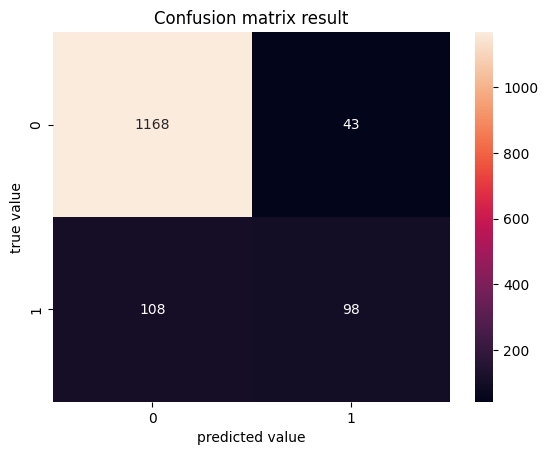

accuracy =  89.34 %
precision =  69.5 %
recall =  47.57 %
f1 score =  56.48 %


In [20]:
LR_model = model_fitting(LogisticRegression(), X_train, X_test, y_train, y_test)

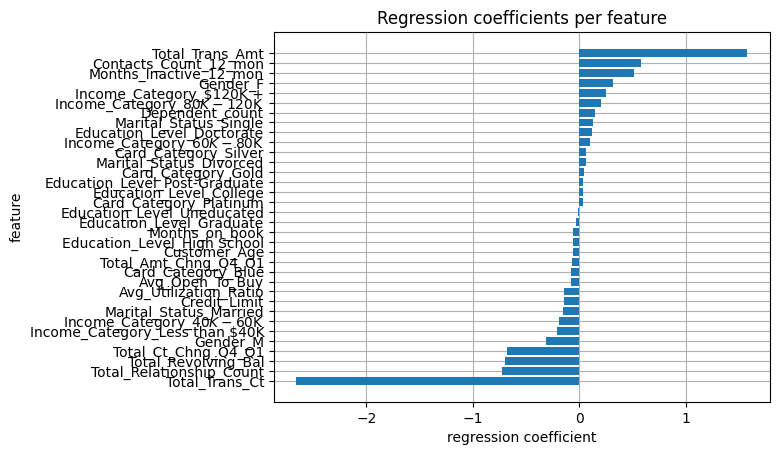

In [21]:
LR_regression_coefficients_per_feature(LR_model, X_train)

### K−近傍法

fit_time:0.0117
score_time:0.5647
test_accuracy:0.8757
test_precision:0.7564
test_recall:0.3341
test_f1:0.4629


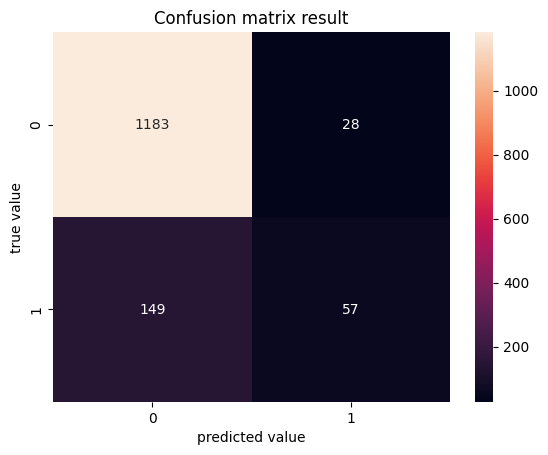

accuracy =  87.51 %
precision =  67.06 %
recall =  27.67 %
f1 score =  39.18 %


In [22]:
KNC_model = model_fitting(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

### 決定木

In [23]:
# 決定木の特徴量重要度を可視化する関数
def DTC_feature_importances(DTC_model, X_train):
    features = X_train.columns.values

    # 特徴量重要度
    importances = DTC_model.feature_importances_

    for n, v in zip(features, importances):
        print(f'importance of {n} is :{v}')

    # 可視化
    plt.figure(figsize=(14,4))
    plt.bar(height=importances, x=X_train.columns)
    plt.ylabel("Feature importances", color='tab:red', fontsize=16, labelpad=20, weight='bold')
    plt.xticks(rotation=90);

fit_time:0.0957
score_time:0.0190
test_accuracy:0.9347
test_precision:0.7974
test_recall:0.7949
test_f1:0.7956


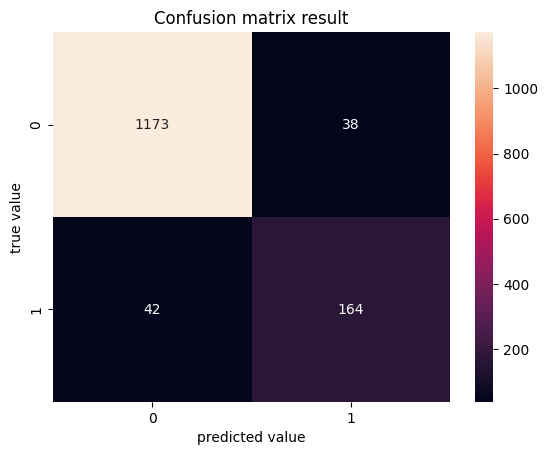

accuracy =  94.35 %
precision =  81.19 %
recall =  79.61 %
f1 score =  80.39 %


In [24]:
DTC_model = model_fitting(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

importance of Customer_Age is :0.019209992788414718
importance of Dependent_count is :0.00580902086359938
importance of Months_on_book is :0.01864024203250999
importance of Total_Relationship_Count is :0.09851537724452569
importance of Months_Inactive_12_mon is :0.023194720459046032
importance of Contacts_Count_12_mon is :0.027594772544819325
importance of Credit_Limit is :0.01452507299971214
importance of Total_Revolving_Bal is :0.20150228055200564
importance of Avg_Open_To_Buy is :0.02967454888256561
importance of Total_Amt_Chng_Q4_Q1 is :0.046826480955251076
importance of Total_Trans_Amt is :0.11878200187321206
importance of Total_Trans_Ct is :0.29991293433083294
importance of Total_Ct_Chng_Q4_Q1 is :0.06596417684868348
importance of Avg_Utilization_Ratio is :0.007649678247653387
importance of Education_Level_College is :0.0
importance of Education_Level_Doctorate is :0.0018336303376340383
importance of Education_Level_Graduate is :0.002547932980772741
importance of Education_Level_

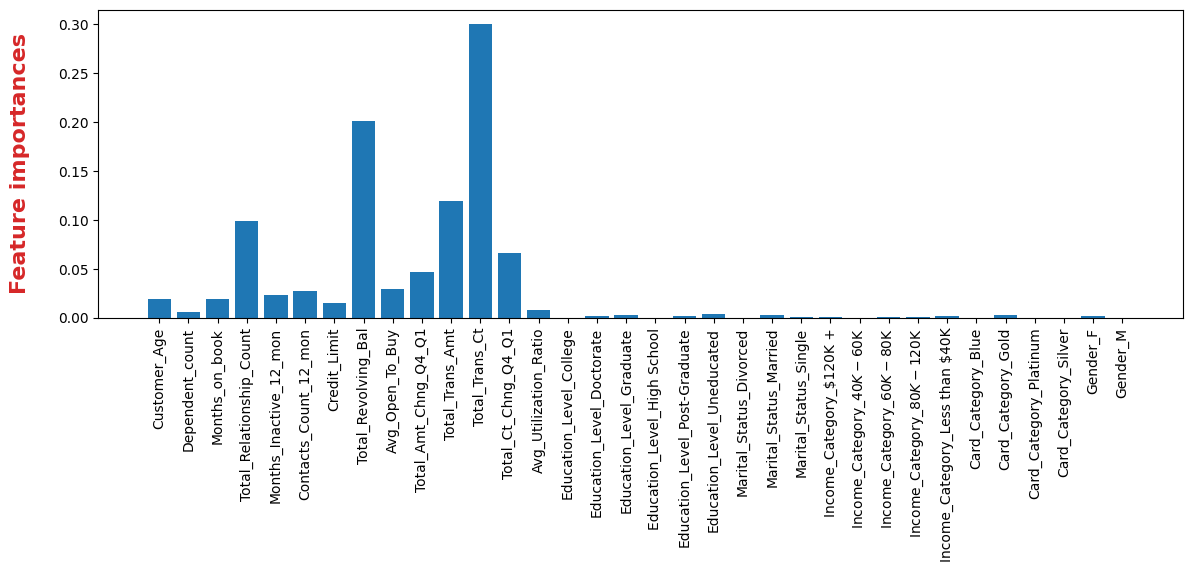

In [25]:
DTC_feature_importances(DTC_model, X_train)

## SMOTEでオーバーサンプリングする

In [26]:
# SMOTEの初期化と適用
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
# オーバーサンプリング後のクラス分布の確認
print(y_smote.value_counts())

0    4757
1    4757
Name: Attrition_Flag, dtype: int64


In [27]:
df_smote = pd.merge(y_smote, X_smote, left_index=True, right_index=True)
df_smote

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Gender_F,Gender_M
0,0,-1.660025,-1.035808,-2.746968,-0.530569,-0.344317,-0.411332,-0.191418,0.717134,-0.255107,...,2.003715,-0.429546,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755,-0.954298,0.954298
1,0,0.827334,-1.035808,0.877106,1.412015,0.660674,-0.411332,-0.692655,-0.644501,-0.634930,...,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755,1.047890,-1.047890
2,1,0.702966,-1.810066,0.002330,-1.178096,-0.344317,0.493777,-0.773057,-0.233302,-0.751867,...,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755,1.047890,-1.047890
3,1,-0.167610,2.061228,0.002330,0.116959,0.660674,0.493777,-0.384724,-1.437353,-0.256640,...,2.003715,-0.429546,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755,-0.954298,0.954298
4,0,0.205494,1.286969,-0.872447,1.412015,-1.349309,-0.411332,-0.611125,-0.115113,-0.600540,...,2.003715,-0.429546,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755,-0.954298,0.954298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,1,-0.009332,-0.715149,0.249732,-0.988419,0.366287,0.493777,0.621615,1.601911,0.478759,...,-0.499073,-0.429546,2.211564,-0.806826,0.270562,-0.107571,-0.039445,-0.241755,-0.954298,0.954298
9510,1,1.183984,0.904360,0.002330,0.280732,-0.344317,0.493777,0.341892,-1.437353,0.469567,...,-0.499073,2.328039,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755,-0.954298,0.954298
9511,1,0.077429,0.257181,0.373519,-1.391800,-0.002680,-1.316441,-0.589216,1.255510,-0.700574,...,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755,1.047890,-1.047890
9512,1,-0.326824,2.005496,0.350248,-1.178096,0.660674,1.464037,-0.514474,-1.437353,-0.386317,...,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755,1.047890,-1.047890


In [35]:
df_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9514 entries, 0 to 9513
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Attrition_Flag                  9514 non-null   int64  
 1   Customer_Age                    9514 non-null   float64
 2   Dependent_count                 9514 non-null   float64
 3   Months_on_book                  9514 non-null   float64
 4   Total_Relationship_Count        9514 non-null   float64
 5   Months_Inactive_12_mon          9514 non-null   float64
 6   Contacts_Count_12_mon           9514 non-null   float64
 7   Credit_Limit                    9514 non-null   float64
 8   Total_Revolving_Bal             9514 non-null   float64
 9   Avg_Open_To_Buy                 9514 non-null   float64
 10  Total_Amt_Chng_Q4_Q1            9514 non-null   float64
 11  Total_Trans_Amt                 9514 non-null   float64
 12  Total_Trans_Ct                  95

In [36]:
df_smote.describe()

,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Gender_F,Gender_M
count,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,...,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000
mean,0.500000,0.009060,0.038403,0.003042,-0.151581,0.146935,0.159953,-0.020596,-0.284989,0.004768,...,-0.011805,-0.027351,-0.000154,0.009436,0.005410,-0.013671,-0.008183,0.001804,0.039737,-0.039737
std,0.500026,0.922142,0.943106,0.928844,0.982359,0.904369,0.949162,0.985731,1.065542,0.986048,...,0.980625,0.968065,0.994604,0.996756,0.989720,0.935033,0.853666,1.003297,0.996129,0.996129
min,0.000000,-2.530601,-1.810066,-2.871936,-1.825624,-2.354300,-2.221550,-0.773057,-1.437353,-0.801184,...,-0.499073,-0.429546,-0.452169,-0.806826,-3.696005,-0.107571,-0.039445,-0.241755,-0.954298,-1.047890
25%,0.000000,-0.628302,-0.559105,-0.497543,-0.948461,-0.344317,-0.411332,-0.662380,-1.437353,-0.639716,...,-0.499073,-0.429546,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755,-0.954298,-1.047890
50%,0.500000,-0.021459,0.016430,0.002330,-0.271496,0.368136,0.493777,-0.464501,-0.351491,-0.425084,...,-0.499073,-0.429546,-0.452169,-0.806826,0.270562,-0.107571,-0.039445,-0.241755,-0.486214,0.486214
75%,1.000000,0.679483,0.512710,0.502202,0.764487,0.660674,0.493777,0.191769,0.608795,0.211485,...,-0.499073,-0.429546,-0.452169,1.239425,0.270562,-0.107571,-0.039445,-0.241755,1.047890,0.954298
max,1.000000,2.941589,2.061228,2.501691,1.412015,3.675649,3.209104,2.851727,1.661415,2.977987,...,2.003715,2.328039,2.211564,1.239425,0.270562,9.296223,25.352066,4.136420,1.047890,0.954298


### 相関チェック

<Axes: >

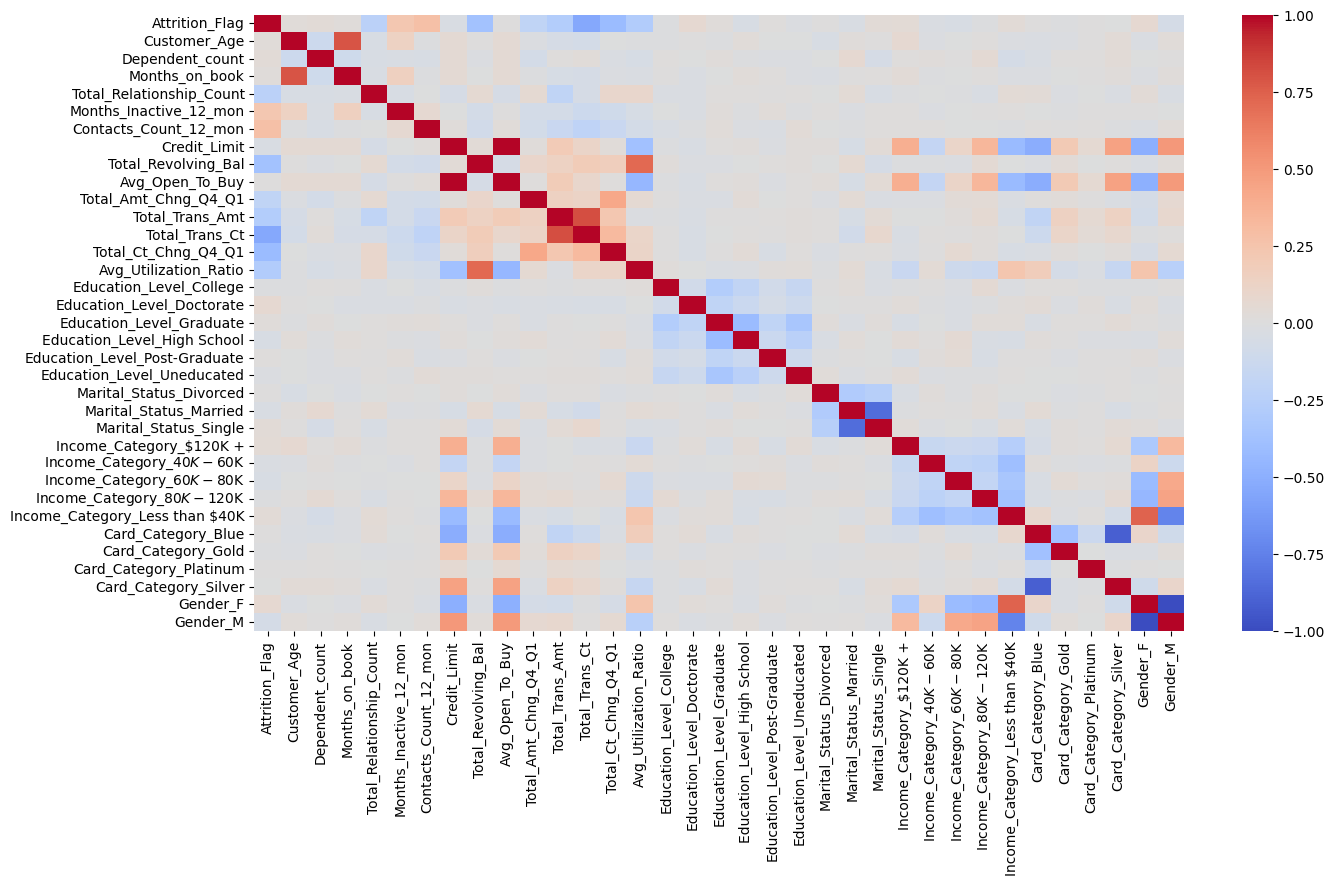

In [28]:
df_smote_corr = df_smote.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(df_smote_corr, cmap='coolwarm', vmax=1.0,vmin=-1.0)

In [29]:
df_smote_corr = df_smote_corr['Attrition_Flag']
df_smote_corr.sort_values(ascending=False)

Attrition_Flag                    1.000000
Contacts_Count_12_mon             0.275950
Months_Inactive_12_mon            0.229945
Education_Level_Doctorate         0.068084
Gender_F                          0.067071
Income_Category_$120K +           0.046402
Dependent_count                   0.035534
Marital_Status_Single             0.034245
Income_Category_Less than $40K    0.032626
Customer_Age                      0.026751
Months_on_book                    0.018162
Education_Level_Graduate          0.016176
Education_Level_Post-Graduate     0.009872
Marital_Status_Divorced           0.006573
Card_Category_Platinum            0.005358
Card_Category_Blue                0.005063
Avg_Open_To_Buy                   0.000753
Card_Category_Silver             -0.001254
Education_Level_College          -0.011093
Card_Category_Gold               -0.011629
Income_Category_$80K - $120K     -0.013949
Education_Level_Uneducated       -0.018219
Income_Category_$40K - $60K      -0.025679
Credit_Limi

### ロジスティック回帰

fit_time:0.0921
score_time:0.0301
test_accuracy:0.8677
test_precision:0.8641
test_recall:0.8728
test_f1:0.8682


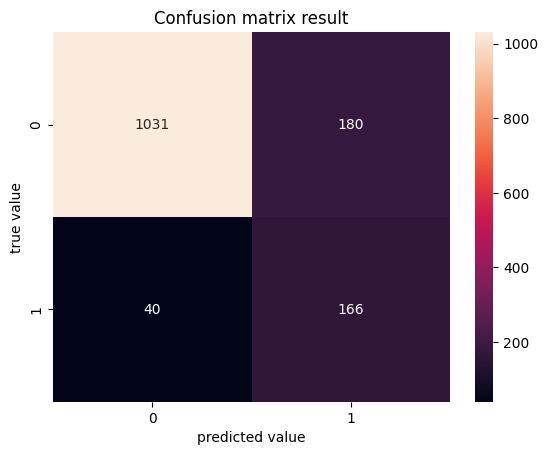

accuracy =  84.47 %
precision =  47.98 %
recall =  80.58 %
f1 score =  60.14 %


In [30]:
LR_model = model_fitting(LogisticRegression(), X_smote, X_test, y_smote, y_test)

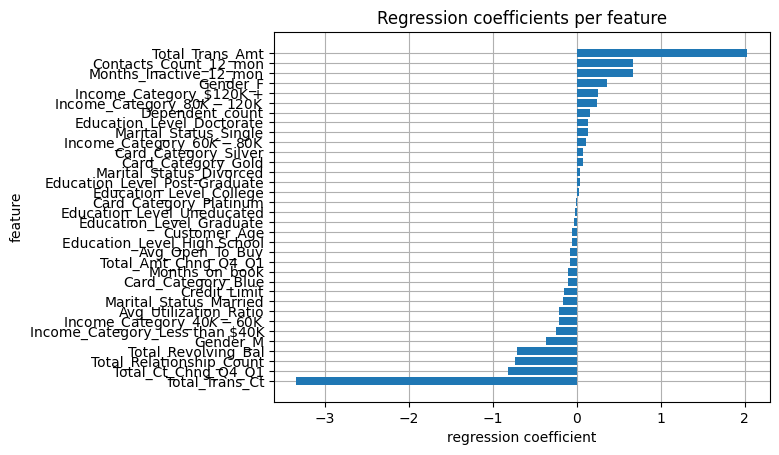

In [31]:
LR_regression_coefficients_per_feature(LR_model, X_smote)

### K−近傍法

fit_time:0.0161
score_time:0.9750
test_accuracy:0.8771
test_precision:0.8103
test_recall:0.9849
test_f1:0.8891


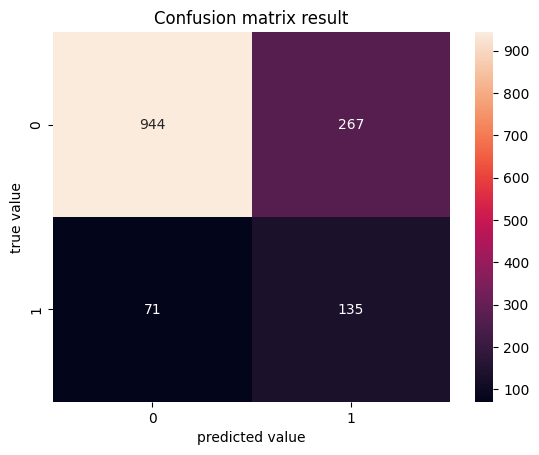

accuracy =  76.15 %
precision =  33.58 %
recall =  65.53 %
f1 score =  44.41 %


In [32]:
KNC_model = model_fitting(KNeighborsClassifier(), X_smote, X_test, y_smote, y_test)

### 決定木

fit_time:0.2931
score_time:0.0301
test_accuracy:0.9315
test_precision:0.9321
test_recall:0.9312
test_f1:0.9306


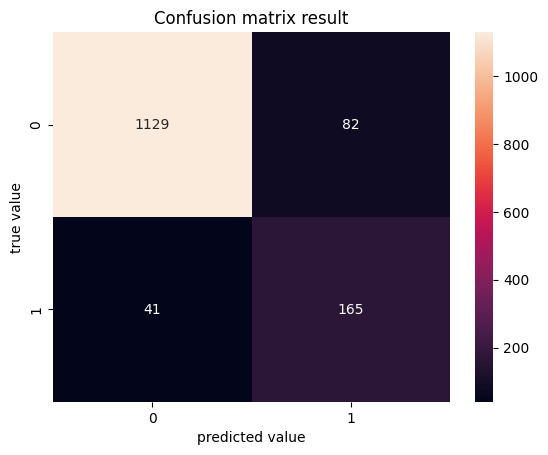

accuracy =  91.32 %
precision =  66.8 %
recall =  80.1 %
f1 score =  72.85 %


In [33]:
DTC_model = model_fitting(DecisionTreeClassifier(), X_smote, X_test, y_smote, y_test)

importance of Customer_Age is :0.02637895842840727
importance of Dependent_count is :0.008266282257170621
importance of Months_on_book is :0.011455013701160078
importance of Total_Relationship_Count is :0.07350112983316064
importance of Months_Inactive_12_mon is :0.028554371941043145
importance of Contacts_Count_12_mon is :0.017590012753327954
importance of Credit_Limit is :0.006349739418998698
importance of Total_Revolving_Bal is :0.1100712490313744
importance of Avg_Open_To_Buy is :0.01569773478114754
importance of Total_Amt_Chng_Q4_Q1 is :0.03129061913915944
importance of Total_Trans_Amt is :0.1357243463052319
importance of Total_Trans_Ct is :0.4595115718861298
importance of Total_Ct_Chng_Q4_Q1 is :0.050021819387387305
importance of Avg_Utilization_Ratio is :0.004916690203063935
importance of Education_Level_College is :0.0012916012940744296
importance of Education_Level_Doctorate is :0.001923479377773554
importance of Education_Level_Graduate is :0.0013246687566454318
importance of

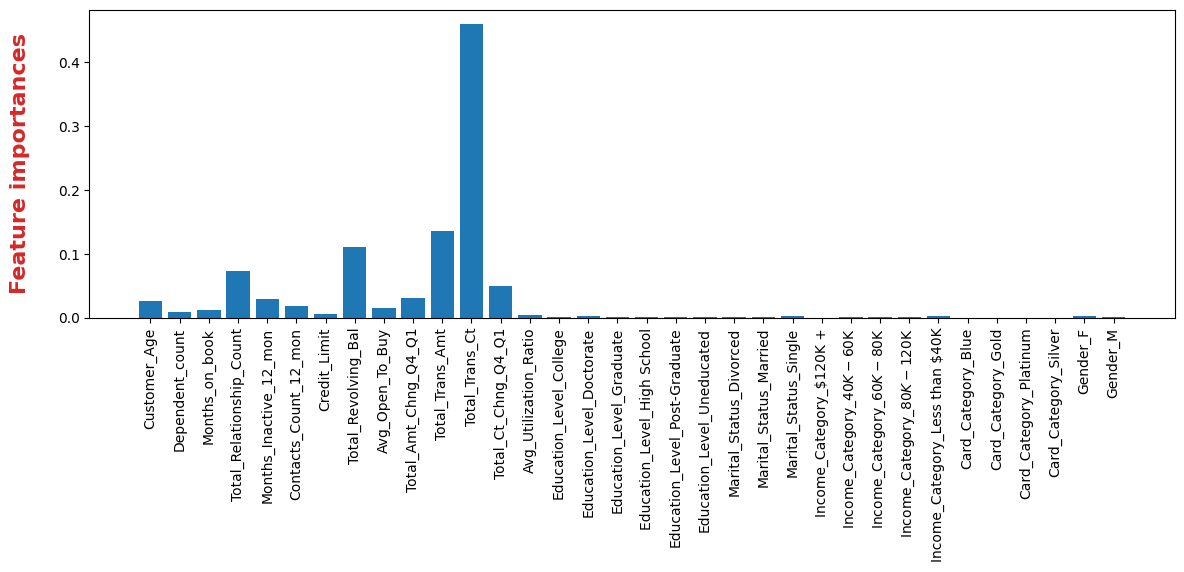

In [34]:
DTC_feature_importances(DTC_model, X_smote)